In [1]:
#%% LOAD PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, timedelta
from scipy.optimize import least_squares
import calendar
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
work_dir=Path("/scratch/fransjevanoors/global_sr")

In [4]:
def regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):
    # rename sr columns
    sr_df = sr_df.rename(columns={'2':'sr_2', '3':'sr_3', '5':'sr_5', '10':'sr_10', '20':'sr_20', '30':'sr_30', '40':'sr_40', '50':'sr_50', '60':'sr_60'})
    
    # concat catchment characteristics with sr dataframe
    df = pd.concat([cc_df,sr_df],axis=1)

    # define columns for regression (dpar and sr column)
    sr_rp = f'sr_{rp}'
    # col = dpar.tolist() + [sr_rp]
    col = dpar + [sr_rp]
    df = df[col]
    
    # treecover
    df_tc = cc_df[['tc', 'ntc', 'nonveg']]

    # select catchments based on treecover threshold
    df = df[df_tc['tc']>tc_th]
    df = df[df_tc['ntc']>ntc_th]
    df = df[df_tc['nonveg']>nonveg_th]

    # exclude nan catchments
    df = df.dropna()

    # exclude sr=zero catchments
    df = df[df[sr_rp]>0]

    # standardize values
    df_st = pd.DataFrame(index=df.index, columns=[col])
    df_st = (df - df.mean())/df.std()
    
    return df, df_st

In [20]:
def regression(df, df_st, dpar, rp):
    sr_rp = f'sr_{rp}' 
    x,sr = df_st[dpar],df_st[sr_rp]
    model = sm.OLS(sr,x)
    results = model.fit()
    par = np.round(results.params,3)
    pred_st = model.predict(par)
    r_sq = np.round(results.rsquared,3)
    r_sq_adj = np.round(results.rsquared_adj,3)
    aic = np.round(results.aic,3)
    pval = np.round(results.pvalues,3)
    nobs = results.nobs

    pred = pred_st * np.std(df[sr_rp]) + np.mean(df[sr_rp])
    x = df[sr_rp]
    y = pred
    
    rmse = np.sqrt(np.mean((x-y)**2))
    rele = np.mean(abs(y-x)/x) * 100
    
    return x,y,par,r_sq,r_sq_adj,aic,rmse,rele,nobs

In [6]:
def regression_table(dpar,par,r_sq,r_sq_adj,aic,nobs, tc_th, ntc_th, nonveg_th):
    b = ['tc_th', 'ntc_th','nonveg_th', 'r_sq', 'r_sq_adj', 'aic', 'pval', 'nobs']
    col = np.concatenate([dpar,b])
    df = pd.DataFrame(index=[0],columns=col)
    df[dpar] = par
    df['tc_th']=tc_th
    df['ntc_th']=ntc_th
    df['nonveg_th']=nonveg_th
    df['r_sq'] = r_sq
    df['r_sq_adj'] = r_sq_adj
    df['aic'] = aic
    # df['pval'] = pval
    df['nobs'] = nobs
    return df


In [7]:
def regression_plot(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):    
    df = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[0]
    df_st = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[1]
    df_out = pd.DataFrame()
    
    if (len(df)>100):
        # regression
        rp = 20
        r = regression(df, df_st, dpar, rp)
        sr, sr_pred = r[0], r[1]
        par,r_sq,r_sq_adj,aic,nobs = r[2],r[3],r[4],r[5],r[6]
        
    # Calculate the point density -> this only works if we have more points
    xy = np.vstack([sr,sr_pred])
    z = gaussian_kde(xy)(xy)
    x,y = sr, sr_pred
    
    #plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    # ax.plot(x,y,'mo',markersize=2)
    ax.scatter(x, y, c=z, s=1)
    ax.plot([0,1200],[0,1200],'r--')
    ax.set_xlabel('Sr water balance (mm)')
    ax.set_ylabel('Sr predicted (mm)')
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    ax.annotate(f'tc > {tc_th}',(20,750),size=13)
    ax.annotate(f'ntc > {ntc_th}',(20,700),size=13)
    ax.annotate(f'nonveg > {nonveg_th}',(20,650),size=13)
    ax.text(0,-150,'Dpar: '+str(dpar),size=11)
    ax.text(0,-190,'Coeff: '+str(np.round(par.values,3)),size=11)
    ax.set_title(f'R^2={np.round(r_sq,3)}, R^2-adj={np.round(r_sq_adj,3)}')
    

In [8]:
def run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):
    # prepare input
    df = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[0]
    df_st = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[1]
    
    df_out = pd.DataFrame()
    
    if (len(df)>100):
        # regression
        rp = 20
        r = regression(df, df_st, dpar, rp)
        sr, sr_pred = r[0], r[1]
        par,r_sq,r_sq_adj,aic,nobs = r[2],r[3],r[4],r[5],r[6]

        # plot results
        # regression_plot(sr,sr_pred,dpar,par,r_sq, tc_th, ntc_th, nonveg_th)

        # make table
        if r_sq_adj>0.2:
            df_out = regression_table(dpar,par,r_sq,r_sq_adj,aic,nobs, tc_th, ntc_th, nonveg_th)

    return df_out

In [28]:
# read the catchment characteristics and sr tables
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar = ['si_ep','phi','si_p','slp_mean','dp','p_mean','idu_mean','si_ep','el_mean','tpi','cla','sp','st','se','sd']
dpar = ['p_mean','ep_mean','idu_mean_l','si_ep','lpf_l']
# return period of Sr estimate
rp = 20

In [29]:
# define the vegetation thresholds for the regression
tc_th_ar = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
ntc_th_ar = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
nonveg_th_ar = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

tc_th_l = tc_th_ar * len(ntc_th_ar) * len(nonveg_th_ar)
tc_th_l.sort()
ntc_th_l = ntc_th_ar * len(tc_th_l)
nonveg_th_l = nonveg_th_ar * len(tc_th_ar)
nonveg_th_l.sort()
nonveg_th_l = nonveg_th_l*int(len(tc_th_l)/2)

li = []

for i in range(len(tc_th_l)):
    tc_th, ntc_th, nonveg_th = tc_th_l[i],ntc_th_l[i],nonveg_th_l[i]
    # print(tc_th,ntc_th,nonveg_th)
    df = run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)
    li.append(df)

In [35]:
frame = pd.concat(li, axis=0) #concatenate dataframes in li
frame.index = np.arange(0,len(frame),1)
# frame

In [51]:
s = frame.sort_values(by=['r_sq_adj'],ascending=False)
# s[0:15]
s

,p_mean,ep_mean,idu_mean_l,si_ep,lpf_l,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
15,0.331,-0.126,0.197,-0.700,0.551,0.0,0.7,0.1,0.529,0.525,1479.253,NaN,705.0
7,0.216,-0.126,0.262,-0.712,0.451,0.0,0.7,0.0,0.517,0.514,1702.867,NaN,803.0
26,0.040,-0.167,0.268,-0.742,0.403,0.1,0.7,0.0,0.474,0.470,1303.756,NaN,590.0
34,-0.035,-0.186,0.306,-0.768,0.306,0.1,0.7,0.1,0.458,0.452,1104.163,NaN,492.0
14,0.286,-0.315,0.163,-0.821,0.452,0.0,0.6,0.1,0.408,0.406,4090.574,NaN,1764.0
6,0.222,-0.406,0.174,-0.934,0.513,0.0,0.6,0.0,0.392,0.391,5092.450,NaN,2172.0
33,0.116,-0.292,0.175,-0.823,0.331,0.1,0.6,0.1,0.380,0.378,3282.452,NaN,1387.0
25,0.105,-0.403,0.182,-0.927,0.439,0.1,0.6,0.0,0.378,0.377,4249.793,NaN,1795.0
17,0.388,0.080,0.328,-0.205,0.265,0.0,0.6,0.2,0.368,0.360,891.456,NaN,371.0
13,0.077,-0.046,0.248,-0.524,0.161,0.0,0.5,0.1,0.332,0.331,7384.124,NaN,3029.0


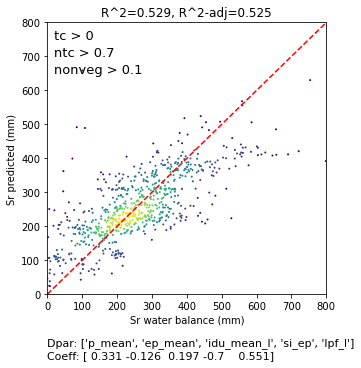

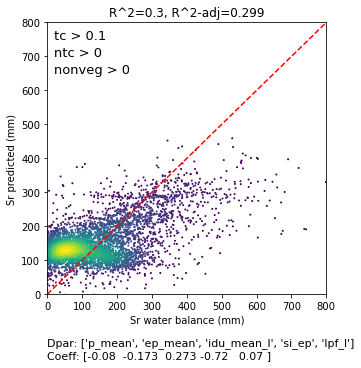

In [161]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar = ['p_mean','ep_mean','idu_mean_l','si_ep','lpf_l']
# return period of Sr estimate
rp = 20

tc_th, ntc_th, nonveg_th = 0, 0.7, 0.1
regression_plot(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)

tc_th, ntc_th, nonveg_th = 0.1, 0, 0
regression_plot(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)

Text(0, 0.5, 'r squared adjusted')

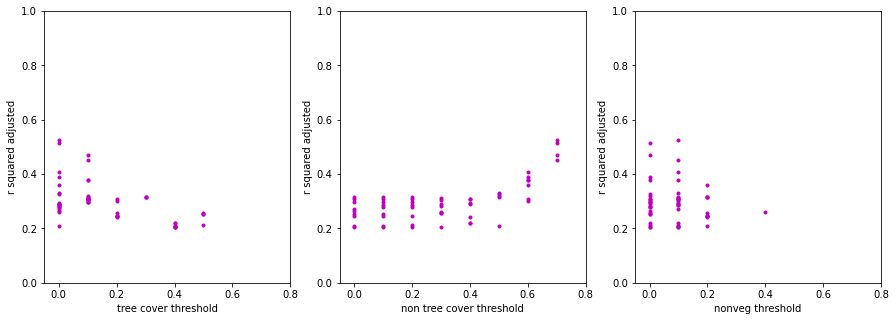

In [32]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.plot(s.tc_th, s.r_sq_adj,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
ax.set_ylim(0,1)
ax.set_xlabel('tree cover threshold')
ax.set_ylabel('r squared adjusted')

ax = fig.add_subplot(132)
ax.plot(s.ntc_th, s.r_sq_adj,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
ax.set_ylim(0,1)
ax.set_xlabel('non tree cover threshold')
ax.set_ylabel('r squared adjusted')

ax = fig.add_subplot(133)
ax.plot(s.nonveg_th, s.r_sq_adj,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
ax.set_ylim(0,1)
ax.set_xlabel('nonveg threshold')
ax.set_ylabel('r squared adjusted')

Text(0, 0.5, 'aic')

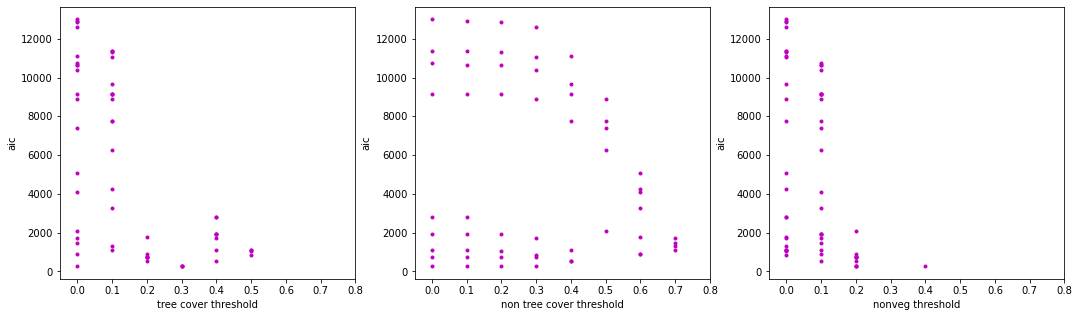

In [33]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
ax.plot(s.tc_th, s.aic,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
# ax.set_ylim(0,1)
ax.set_xlabel('tree cover threshold')
ax.set_ylabel('aic')

ax = fig.add_subplot(132)
ax.plot(s.ntc_th, s.aic,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
# ax.set_ylim(0,1)
ax.set_xlabel('non tree cover threshold')
ax.set_ylabel('aic')

ax = fig.add_subplot(133)
ax.plot(s.nonveg_th, s.aic,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
# ax.set_ylim(0,1)
ax.set_xlabel('nonveg threshold')
ax.set_ylabel('aic')


### TREE COVER BINS

In [62]:
def run_regression_bins(cc_df, sr_df, dpar, rp, rank_nr):
    # prepare input
    df = regression_input_bins(cc_df, sr_df, dpar, rp, rank_nr)[0]
    df_st = regression_input_bins(cc_df, sr_df, dpar, rp, rank_nr)[1]
    
    min_tc, mean_tc, max_tc, mean_ntc = regression_input_bins(cc_df, sr_df, dpar, rp, rank_nr)[2:]
    df_out = pd.DataFrame()
    
    if (len(df)>50):
        # regression
        rp = 20
        r = regression(df, df_st, dpar, rp)
        sr, sr_pred = r[0], r[1]
        par,r_sq,r_sq_adj,aic,rmse,rele,nobs = r[2],r[3],r[4],r[5],r[6],r[7],r[8]

        # plot results
        # regression_plot(sr,sr_pred,dpar,par,r_sq, tc_th, ntc_th, nonveg_th)

        # make table
        # if r_sq_adj>0.1:
        df_out = regression_table_bins(dpar,par,r_sq,r_sq_adj,aic,rmse,rele,nobs, min_tc,mean_tc,max_tc,mean_ntc,rank_nr)
        
        #plot
        xy = np.vstack([sr,sr_pred])
        z = gaussian_kde(xy)(xy)
        x,y = sr, sr_pred
    
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        # ax.plot(x,y,'mo',markersize=2)
        ax.scatter(x, y, c=z, s=1)
        ax.plot([0,1200],[0,1200],'r--')
        ax.set_xlabel('Sr water balance (mm)')
        ax.set_ylabel('Sr predicted (mm)')
        ax.set_xlim(0,800)
        ax.set_ylim(0,800)
        ax.annotate(f'tc mean: {np.round(mean_tc,2)}',(20,750),size=13)
        ax.annotate(f'ntc mean: {np.round(mean_ntc,2)}',(20,700),size=13)
        ax.annotate(f'nonveg mean:{np.round((1-mean_tc-mean_ntc),2)}',(20,650),size=13)
        par = np.round(par.values,3)
        ax.text(0,-150,f'{dpar[0]}: {par[0]};  {dpar[1]}: {par[1]}',size=13)
        ax.text(0,-200,f'{dpar[2]}: {par[2]};  {dpar[3]}: {par[3]}',size=13)
        ax.text(0,-250,f'{dpar[4]}: {par[4]};  {dpar[5]}: {par[5]}',size=13)
        ax.set_title(f'R^2={np.round(r_sq,3)}, RMSE={np.round(rmse,2)}mm')
        fig.savefig(f'{work_dir}/output/figures/regression/regression_{np.round(mean_tc,2)}.jpg',bbox_inches='tight',dpi=300)
        
        return df_out

In [27]:
def regression_input_bins(cc_df, sr_df, dpar, rp, rank_nr):
    # rename sr columns
    sr_df = sr_df.rename(columns={'2':'sr_2', '3':'sr_3', '5':'sr_5', '10':'sr_10', '20':'sr_20', '30':'sr_30', '40':'sr_40', '50':'sr_50', '60':'sr_60'})
    
    # concat catchment characteristics with sr dataframe
    df = pd.concat([cc_df,sr_df],axis=1)
    
    # select catchments based on tree cover bins
    df = df.sort_values(by=['tc'])
    df = df.iloc[rank_nr[0]:rank_nr[1]]
    min_tc, mean_tc, max_tc = df.tc.min(), df.tc.mean(), df.tc.max()
    mean_ntc = df.ntc.mean()

    # define columns for regression (dpar and sr column)
    sr_rp = f'sr_{rp}'
    # col = dpar.tolist() + [sr_rp]
    col = dpar + [sr_rp]
    df = df[col]
    
    # exclude nan catchments
    df = df.dropna()

    # exclude sr=zero catchments
    df = df[df[sr_rp]>0]

    # standardize values
    df_st = pd.DataFrame(index=df.index, columns=[col])
    df_st = (df - df.mean())/df.std()
    
    return df, df_st, min_tc, mean_tc, max_tc,mean_ntc

In [28]:
def regression_table_bins(dpar,par,r_sq,r_sq_adj,aic,rmse,rele,nobs, min_tc,mean_tc,max_tc,mean_ntc,rank_nr):
    b = ['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg', 'r_sq', 'r_sq_adj', 'aic','rmse','rele', 'nobs']
    col = np.concatenate([dpar,b])
    df = pd.DataFrame(index=[0],columns=col)
    df[dpar] = par
    df['rank_low']=rank_nr[0]
    df['rank_high']=rank_nr[1]
    df['mean_tc']=np.round(mean_tc,2)
    df['mean_ntc']=np.round(mean_ntc,2)
    df['mean_nonveg']= np.round((1-mean_tc-mean_ntc),2)
    df['r_sq'] = r_sq
    df['r_sq_adj'] = r_sq_adj
    df['aic'] = aic
    df['rmse']=rmse
    df['rele']=rele
    # df['pval'] = pval
    df['nobs'] = nobs
    return df

IndexError: list index out of range

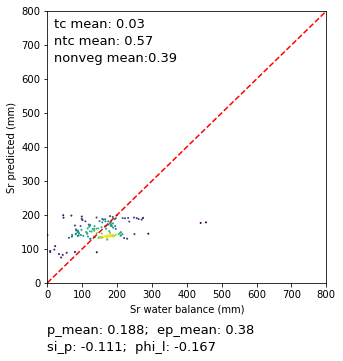

In [63]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# cc_df = cc_df.sort_values(by=['mean_tc'])
dpar = ['p_mean','ep_mean','si_p','phi_l']
total_bins = 30
dif = np.int(len(cc_df)/total_bins)
df_score = pd.DataFrame(index=np.arange(0,total_bins,1),columns=['rank_low','rank_high','#points','R2','R2-adj','AIC','mean_tc','mean_ntc','mean_nonveg'])
df_par = pd.DataFrame(index=np.arange(0,total_bins,1),columns=dpar)
al = []
for i in range(total_bins):
    rank_nr = [i*dif,(i+1)*dif]
    a=run_regression_bins(cc_df, sr_df, dpar, rp, rank_nr)
    al.append(a)
df = pd.concat(al)
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','idu_mean_l','si_ep','lpf_l','r_sq','r_sq_adj','aic','nobs']]
df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','si_p','phi_l','r_sq','r_sq_adj','aic','nobs']]

df.index = np.arange(1,len(df)+1,1)
df.to_csv(f'{work_dir}/output/regression/tc_bins_regression_table.csv')


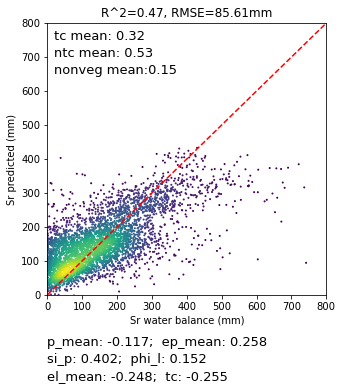

In [70]:
# 1 bins for all catchments together
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
rp=20

# cc_df = cc_df.sort_values(by=['mean_tc'])
dpar = ['p_mean','ep_mean','si_p','phi_l','el_mean','tc']
total_bins = 4
dif = np.int(len(cc_df)/total_bins)
df_score = pd.DataFrame(index=np.arange(0,total_bins,1),columns=['rank_low','rank_high','#points','R2','R2-adj','AIC','mean_tc','mean_ntc','mean_nonveg'])
df_par = pd.DataFrame(index=np.arange(0,total_bins,1),columns=dpar)
al = []

total_bins=1
ranks=[1500,8640]
for i in range(total_bins):
    rank_nr = [ranks[i],ranks[i+1]]
    a=run_regression_bins(cc_df, sr_df, dpar, rp, rank_nr)
    al.append(a)
    
df = pd.concat(al)
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','idu_mean_l','si_ep','lpf_l','r_sq','r_sq_adj','aic','nobs']]
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','si_p','phi_l','r_sq','r_sq_adj','aic','nobs']]

df.index = np.arange(1,len(df)+1,1)
# df.to_csv(f'{work_dir}/output/regression/tc_bins_regression_table.csv')

In [71]:
df

,p_mean,ep_mean,si_p,phi_l,el_mean,tc,rank_low,rank_high,mean_tc,mean_ntc,mean_nonveg,r_sq,r_sq_adj,aic,rmse,rele,nobs
1,-0.117,0.258,0.402,0.152,-0.248,-0.255,1500,8640,0.32,0.53,0.15,0.47,0.469,9658.648,85.609807,543.171112,4380.0


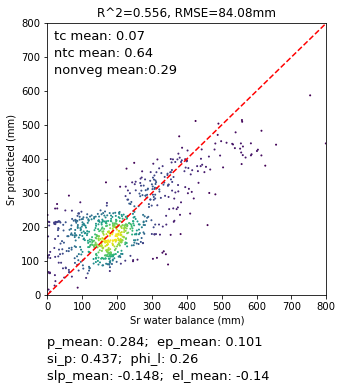

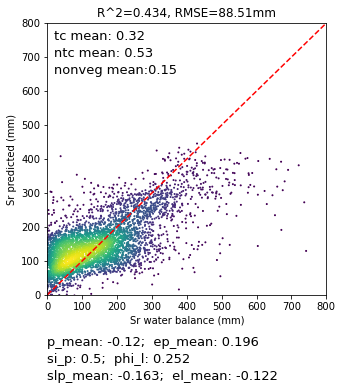

In [30]:
# 2 bins for low and high vegetation
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
rp=20

# cc_df = cc_df.sort_values(by=['mean_tc'])
dpar = ['p_mean','ep_mean','si_p','phi_l','slp_mean','el_mean']
total_bins = 4
dif = np.int(len(cc_df)/total_bins)
df_score = pd.DataFrame(index=np.arange(0,total_bins,1),columns=['rank_low','rank_high','#points','R2','R2-adj','AIC','mean_tc','mean_ntc','mean_nonveg'])
df_par = pd.DataFrame(index=np.arange(0,total_bins,1),columns=dpar)
al = []

ranks=[0,1440,6624,7776,8640]
total_bins=2
ranks=[0,1500,8640]
for i in range(total_bins):
    rank_nr = [ranks[i],ranks[i+1]]
    a=run_regression_bins(cc_df, sr_df, dpar, rp, rank_nr)
    al.append(a)
    
df = pd.concat(al)
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','idu_mean_l','si_ep','lpf_l','r_sq','r_sq_adj','aic','nobs']]
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','si_p','phi_l','r_sq','r_sq_adj','aic','nobs']]

df.index = np.arange(1,len(df)+1,1)
# df.to_csv(f'{work_dir}/output/regression/tc_bins_regression_table.csv')

IndexError: list index out of range

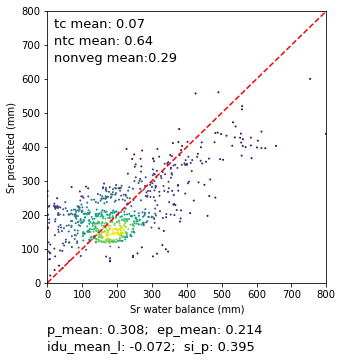

In [31]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# cc_df = cc_df.sort_values(by=['mean_tc'])
dpar = ['p_mean','ep_mean','idu_mean_l','si_p']
total_bins = 4
dif = np.int(len(cc_df)/total_bins)
df_score = pd.DataFrame(index=np.arange(0,total_bins,1),columns=['rank_low','rank_high','#points','R2','R2-adj','AIC','mean_tc','mean_ntc','mean_nonveg'])
df_par = pd.DataFrame(index=np.arange(0,total_bins,1),columns=dpar)
al = []

ranks=[0,1440,6624,7776,8640]
total_bins=2
ranks=[0,1500,8640]
for i in range(total_bins):
    rank_nr = [ranks[i],ranks[i+1]]
    a=run_regression_bins(cc_df, sr_df, dpar, rp, rank_nr)
    al.append(a)
    
df = pd.concat(al)
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','idu_mean_l','si_ep','lpf_l','r_sq','r_sq_adj','aic','nobs']]
# df = df[['rank_low','rank_high','mean_tc','mean_ntc','mean_nonveg','p_mean','ep_mean','si_p','phi_l','r_sq','r_sq_adj','aic','nobs']]

df.index = np.arange(1,len(df)+1,1)
# df.to_csv(f'{work_dir}/output/regression/tc_bins_regression_table.csv')

In [152]:
df

,rank_low,rank_high,mean_tc,mean_ntc,mean_nonveg,p_mean,ep_mean,si_p,phi_l,r_sq,r_sq_adj,aic,nobs
1,0,1440,0.07,0.64,0.29,0.338,0.177,0.369,0.181,0.495,0.492,1575.380,728.0
2,1440,6624,0.25,0.59,0.16,-0.155,0.235,0.441,0.226,0.343,0.343,8024.362,3317.0
3,6624,7776,0.44,0.42,0.14,-0.013,0.132,0.394,0.289,0.340,0.336,1542.478,634.0
4,7776,8640,0.56,0.33,0.11,-0.113,0.327,0.360,0.130,0.276,0.269,1166.640,461.0


In [158]:
df

,rank_low,rank_high,mean_tc,mean_ntc,mean_nonveg,p_mean,ep_mean,si_p,phi_l,r_sq,r_sq_adj,aic,nobs
1,0,2000,0.09,0.65,0.26,0.201,0.171,0.391,0.212,0.425,0.422,2484.228,1084.0
2,2000,8640,0.33,0.52,0.15,-0.134,0.199,0.434,0.295,0.335,0.334,9864.614,4056.0


In [160]:
df

,rank_low,rank_high,mean_tc,mean_ntc,mean_nonveg,p_mean,ep_mean,si_p,phi_l,r_sq,r_sq_adj,aic,nobs
1,0,1500,0.07,0.64,0.29,0.332,0.168,0.381,0.188,0.503,0.500,1632.450,760.0
2,1500,8640,0.32,0.53,0.15,-0.139,0.194,0.468,0.286,0.369,0.369,10418.072,4380.0


In [ ]:
def regression_plot(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):    
    df = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[0]
    df_st = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[1]
    df_out = pd.DataFrame()
    
    if (len(df)>100):
        # regression
        rp = 20
        r = regression(df, df_st, dpar, rp)
        sr, sr_pred = r[0], r[1]
        par,r_sq,r_sq_adj,aic,nobs = r[2],r[3],r[4],r[5],r[6]
        
    # Calculate the point density -> this only works if we have more points
    xy = np.vstack([sr,sr_pred])
    z = gaussian_kde(xy)(xy)
    x,y = sr, sr_pred
    
    #plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    # ax.plot(x,y,'mo',markersize=2)
    ax.scatter(x, y, c=z, s=1)
    ax.plot([0,1200],[0,1200],'r--')
    ax.set_xlabel('Sr water balance (mm)')
    ax.set_ylabel('Sr predicted (mm)')
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    ax.annotate(f'tc > {tc_th}',(20,750),size=13)
    ax.annotate(f'ntc > {ntc_th}',(20,700),size=13)
    ax.annotate(f'nonveg > {nonveg_th}',(20,650),size=13)
    ax.text(0,-150,'Dpar: '+str(dpar),size=11)
    ax.text(0,-190,'Coeff: '+str(np.round(par.values,3)),size=11)
    ax.set_title(f'R^2={np.round(r_sq,3)}, R^2-adj={np.round(r_sq_adj,3)}')
    

In [13]:
# read the catchment characteristics and sr tables
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar_all = ['phi','si_p','slp_mean','dp','p_mean','idu_mean','si_ep','el_mean','tpi','cla','sp','st','se','sd']

# return period of Sr estimate
rp = 20

its = 15

# define the vegetation thresholds for the regression
tc_th_ar = [0,0.2,0.4,0.7]
ntc_th_ar = [0,0.2,0.4,0.7]
nonveg_th_ar = [0,0.2,0.4,0.7]

tc_th_l = tc_th_ar * len(ntc_th_ar) * len(nonveg_th_ar)
tc_th_l.sort()
ntc_th_l = ntc_th_ar * len(tc_th_l)
nonveg_th_l = nonveg_th_ar * len(tc_th_ar)
nonveg_th_l.sort()
nonveg_th_l = nonveg_th_l*int(len(tc_th_l)/2)

res = []
for i in range(its):
    li = []
    # Generate a random number of features
    N_columns =  list(np.random.choice(range(len(dpar_all)),1)+1)
    # print(N_columns)
    
    # Given the number of features, generate features without replacement
    columns = list(np.random.choice(range(len(dpar_all)), N_columns, replace=False))
    # print(columns)
    
    dpar_sel = np.array(dpar_all)[columns]
    # print(dpar_sel)
    
    for j in range(len(tc_th_l)):
        tc_th, ntc_th, nonveg_th = tc_th_l[j],ntc_th_l[j],nonveg_th_l[j]
        # print(tc_th,ntc_th,nonveg_th)
        df = run_regression(cc_df, sr_df, dpar_sel, rp, tc_th, ntc_th, nonveg_th)
        # if (df.empty==False):
        li.append(df)
    if (len(li)>0):
        frame = pd.concat(li, axis=0) #concatenate dataframes in li
        frame.index = np.arange(0,len(frame),1)
        cols = np.concatenate([dpar_all,['tc_th', 'ntc_th','nonveg_th', 'r_sq', 'r_sq_adj', 'aic', 'pval', 'nobs']])
        res2 = pd.DataFrame(index=[], columns=cols)
        res2[frame.columns] = frame
        res.append(res2)

In [14]:
df_f = pd.concat(res, axis=0)
df_f.index = np.arange(0,len(df_f),1)
df_f

,phi,si_p,slp_mean,dp,p_mean,idu_mean,si_ep,el_mean,tpi,cla,...,se,sd,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
0,0.248,0.636,NaN,NaN,NaN,NaN,NaN,-0.208,0.106,NaN,...,0.018,NaN,0.0,0.0,0.0,0.432,0.431,11164.638,NaN,4906.0
1,0.249,0.639,NaN,NaN,NaN,NaN,NaN,-0.208,0.104,NaN,...,0.015,NaN,0.0,0.2,0.0,0.434,0.433,11103.875,NaN,4888.0
2,0.244,0.653,NaN,NaN,NaN,NaN,NaN,-0.216,0.101,NaN,...,0.044,NaN,0.0,0.4,0.0,0.432,0.431,9617.442,NaN,4228.0
3,0.241,0.695,NaN,NaN,NaN,NaN,NaN,-0.211,0.045,NaN,...,-0.030,NaN,0.0,0.7,0.0,0.531,0.526,1605.281,NaN,765.0
4,0.237,0.276,NaN,NaN,NaN,NaN,NaN,-0.275,0.167,NaN,...,0.028,NaN,0.2,0.4,0.2,0.428,0.408,491.670,NaN,210.0
5,NaN,NaN,NaN,0.016,-0.023,0.439,-0.481,-0.174,NaN,-0.037,...,-0.102,0.040,0.0,0.7,0.0,0.512,0.507,1717.299,NaN,802.0
6,0.153,NaN,-0.588,NaN,0.299,NaN,NaN,0.146,NaN,-0.029,...,-0.010,NaN,0.2,0.4,0.2,0.423,0.404,500.151,NaN,213.0
7,0.151,NaN,-0.153,NaN,NaN,0.380,-0.337,-0.105,0.055,NaN,...,0.025,NaN,0.0,0.2,0.0,0.403,0.402,11366.568,NaN,4888.0
8,0.200,NaN,-0.067,NaN,NaN,0.452,-0.408,-0.071,0.011,NaN,...,-0.087,NaN,0.0,0.7,0.0,0.537,0.533,1596.174,NaN,765.0
9,0.253,NaN,-0.239,NaN,NaN,0.194,-0.108,-0.090,0.094,NaN,...,0.016,NaN,0.2,0.4,0.2,0.427,0.404,494.098,NaN,210.0


In [15]:
s = df_f.sort_values(by=['r_sq_adj'],ascending=False)
s[0:15]

,phi,si_p,slp_mean,dp,p_mean,idu_mean,si_ep,el_mean,tpi,cla,...,se,sd,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
14,0.233,0.408,-0.060,0.028,0.088,0.194,-0.223,-0.134,0.033,-0.010,...,-0.085,NaN,0.0,0.7,0.0,0.579,0.571,1534.614,NaN,765.0
22,0.277,0.549,NaN,NaN,0.125,0.163,NaN,-0.183,NaN,0.043,...,-0.059,NaN,0.0,0.7,0.0,0.557,0.553,1637.333,NaN,802.0
8,0.200,NaN,-0.067,NaN,NaN,0.452,-0.408,-0.071,0.011,NaN,...,-0.087,NaN,0.0,0.7,0.0,0.537,0.533,1596.174,NaN,765.0
29,NaN,0.524,0.015,0.026,0.048,NaN,-0.340,-0.247,0.062,-0.070,...,-0.105,0.046,0.0,0.7,0.0,0.534,0.527,1607.807,NaN,765.0
3,0.241,0.695,NaN,NaN,NaN,NaN,NaN,-0.211,0.045,NaN,...,-0.030,NaN,0.0,0.7,0.0,0.531,0.526,1605.281,NaN,765.0
5,NaN,NaN,NaN,0.016,-0.023,0.439,-0.481,-0.174,NaN,-0.037,...,-0.102,0.040,0.0,0.7,0.0,0.512,0.507,1717.299,NaN,802.0
18,0.216,0.065,-0.472,-0.085,0.350,0.283,-0.103,0.181,0.265,-0.234,...,-0.008,NaN,0.2,0.4,0.2,0.512,0.480,466.035,NaN,208.0
10,NaN,0.597,NaN,NaN,NaN,0.147,NaN,-0.270,NaN,NaN,...,0.026,NaN,0.0,0.7,0.0,0.482,0.478,1760.384,NaN,803.0
12,0.231,0.450,-0.140,0.008,-0.080,0.105,-0.162,-0.178,-0.006,0.131,...,0.012,NaN,0.0,0.2,0.0,0.474,0.473,10731.940,NaN,4879.0
13,0.234,0.467,-0.158,0.007,-0.082,0.109,-0.142,-0.177,-0.010,0.123,...,0.036,NaN,0.0,0.4,0.0,0.470,0.469,9322.511,NaN,4222.0
